# HW3

Yael Zorea - 209308675

Ilay Yoeli - 318260965

Yarden Greenpeter - 318517653


In [15]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## 1.1 The Clique Functions in the Ising Model

In [16]:
# Ex1
def G(row_s, Temp):
    return np.exp((1/Temp) * np.sum(row_s[:-1] * row_s[1:]))

# Ex2
def F(row_s, row_t, Temp):
    return np.exp((1/Temp) * np.sum(row_s * row_t))

## 1.2 Brute Force on Small Lattices

In [17]:
#Ex3
def compute_Z_2x2(Temp):
    Z = 0
    for x11 in [-1, 1]:
        for x12 in [-1, 1]:
            for x21 in [-1, 1]:
                for x22 in [-1, 1]:
                    row1 = np.array([x11, x12])
                    row2 = np.array([x21, x22])
                    Z += G(row1, Temp) * G(row2, Temp) * F(row1, row2, Temp)
    return Z

# Compute for three temperatures
for Temp in [1, 1.5, 2]:
    Z = compute_Z_2x2(Temp)
    print(f"Z_Temp for 2x2 lattice at Temp={Temp}: {Z}")


Z_Temp for 2x2 lattice at Temp=1: 121.23293134406595
Z_Temp for 2x2 lattice at Temp=1.5: 40.922799092745386
Z_Temp for 2x2 lattice at Temp=2: 27.048782764334526


In [18]:
#Ex4
def compute_Z_3x3(Temp):
    Z = 0
    for x11 in [-1, 1]:
        for x12 in [-1, 1]:
            for x13 in [-1, 1]:
                for x21 in [-1, 1]:
                    for x22 in [-1, 1]:
                        for x23 in [-1, 1]:
                            for x31 in [-1, 1]:
                                for x32 in [-1, 1]:
                                    for x33 in [-1, 1]:
                                        row1 = np.array([x11, x12, x13])
                                        row2 = np.array([x21, x22, x23])
                                        row3 = np.array([x31, x32, x33])
                                        Z += (G(row1, Temp) * G(row2, Temp) * G(row3, Temp) *
                                              F(row1, row2, Temp) * F(row2, row3, Temp))
    return Z

# Compute for three temperatures
for Temp in [1, 1.5, 2]:
    Z = compute_Z_3x3(Temp)
    print(f"Z_Temp for 3x3 lattice at Temp={Temp}: {Z}")

Z_Temp for 3x3 lattice at Temp=1: 365645.7491357704
Z_Temp for 3x3 lattice at Temp=1.5: 10565.421983514265
Z_Temp for 3x3 lattice at Temp=2: 2674.518123060087


In [19]:
# Helping function computes the ys → (x(s,i)) i=1to8 mapping.
def y2row(y,width=8):
  """
  y: an integer in (0,...,(2**width)-1)
  """
  if not 0<=y<=(2**width)-1:
    raise ValueError(y)
  my_str=np.binary_repr(y,width=width)
  # my_list = map(int,my_str) # Python 2
  my_list = list(map(int,my_str)) # Python 3
  my_array = np.asarray(my_list)
  my_array[my_array==0]=-1
  row=my_array
  return row

In [20]:
# Ex5
def compute_Z_2x2_chain(Temp):
    Z = 0
    for y1 in range(4):
        for y2 in range(4):
            row1 = y2row(y1, width=2)
            row2 = y2row(y2, width=2)
            Z += G(row1, Temp) * G(row2, Temp) * F(row1, row2, Temp)
    return Z

# Compute for three temperatures
for Temp in [1, 1.5, 2]:
    Z = compute_Z_2x2_chain(Temp)
    print(f"Z_Temp for 2x2 lattice (chain) at Temp={Temp}: {Z}")

Z_Temp for 2x2 lattice (chain) at Temp=1: 121.23293134406595
Z_Temp for 2x2 lattice (chain) at Temp=1.5: 40.922799092745386
Z_Temp for 2x2 lattice (chain) at Temp=2: 27.048782764334526


In [21]:
# Ex6
def compute_Z_3x3_chain(Temp):
    Z = 0
    for y1 in range(8):
        for y2 in range(8):
            for y3 in range(8):
                row1 = y2row(y1, width=3)
                row2 = y2row(y2, width=3)
                row3 = y2row(y3, width=3)
                Z += (G(row1, Temp) * G(row2, Temp) * G(row3, Temp) *
                      F(row1, row2, Temp) * F(row2, row3, Temp))
    return Z

# Compute for three temperatures
for Temp in [1, 1.5, 2]:
    Z = compute_Z_3x3_chain(Temp)
    print(f"Z_Temp for 3x3 lattice (chain) at Temp={Temp}: {Z}")

Z_Temp for 3x3 lattice (chain) at Temp=1: 365645.7491357704
Z_Temp for 3x3 lattice (chain) at Temp=1.5: 10565.421983514265
Z_Temp for 3x3 lattice (chain) at Temp=2: 2674.518123060087


## 1.3 Dynamic Programming on an 8×8 Lattice

In [22]:
import numpy as np
from scipy.special import logsumexp

def exact_sampler(Temp):
    # Forward pass
    T = [np.zeros(256, dtype=np.float64) for _ in range(8)] # List of 8 arrays, each of size 256

    # Initialize T1
    y_rows = np.array([y2row(y) for y in range(256)])
    G_values = (1/Temp) * np.sum(y_rows[:, :-1] * y_rows[:, 1:], axis=1)
    F_values = (1/Temp) * np.dot(y_rows, y_rows.T)

    T[0] = logsumexp(G_values[:, np.newaxis] + F_values, axis=0) # Eqution (18)
    # log(a + b) = log(exp(log(a)) + exp(log(b))) = max(log(a), log(b)) + log(1 + exp(min(log(a), log(b)) - max(log(a), log(b))))

    # Compute T2 to T7
    for k in range(1, 7):
        T[k] = logsumexp(T[k-1][:, np.newaxis] + G_values[:, np.newaxis] + F_values, axis=0) # Eqution (19)
        # computes log(sum(exp(T[k-1] + G + F))) for each possible state

    # Compute T8 (Z_Temp) --> Equation (20)
    log_Z_Temp = logsumexp(T[6] + G_values)

    # Backward pass (sampling)
    sample = np.zeros((8, 8), dtype=int)

    # Compute p8 --> Equation (21)
    log_p8 = T[6] + G_values - log_Z_Temp
    p8 = np.exp(log_p8)

    # Compute conditional probabilities p7|8 to p1|2 --> Equations (22)
    conditionals = [np.zeros((256, 256), dtype=np.float64) for _ in range(7)]
    for k in range(6, -1, -1):
        log_conditionals = (T[k-1][:, np.newaxis] + G_values[:, np.newaxis] + F_values) - T[k]
        conditionals[k] = np.exp(log_conditionals)

    # Compute p1|2 --> Equation (23)
    log_conditionals = (G_values[:, np.newaxis] + F_values) - T[0]
    conditionals[0] = np.exp(log_conditionals)

    # Sampling
    y8 = np.random.choice(256, p=p8) # select a single value from a set of possibilities based on a probability distribution
    sample[7] = y2row(y8)

    for k in range(6, -1, -1):
        y_k = np.random.choice(256, p=conditionals[k][:, y8])
        sample[k] = y2row(y_k)
        y8 = y_k # For the next iteration

    return sample

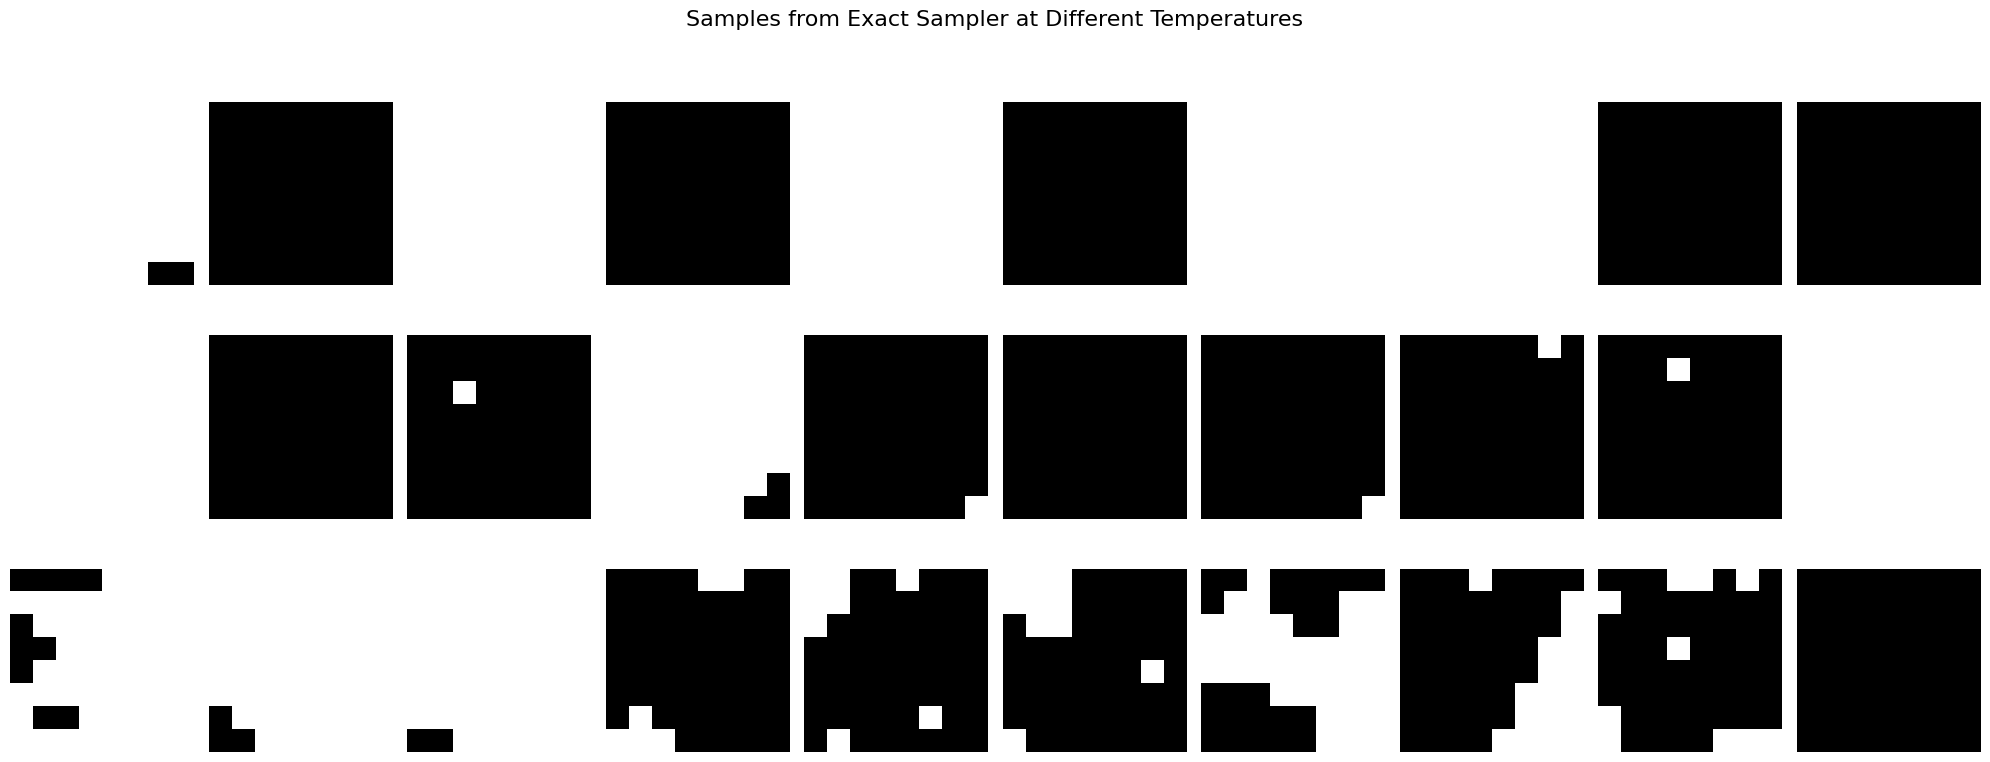

In [23]:
# Generate 10 samples for each temperature
temperatures = [1, 1.5, 2]
n_samples = 10

fig, axes = plt.subplots(3, 10, figsize=(20, 8))

for i, Temp in enumerate(temperatures):
    for j in range(n_samples):
        #print(f"Temp = {Temp}, sample number {j+1}")
        sample = exact_sampler(Temp)
        axes[i, j].imshow(sample, cmap='binary', interpolation='None', vmin=-1, vmax=1)
        axes[i, j].axis('off')
        #axes[i, j].set_title(f'Sample {j+1}', fontsize=10)

# Add an overall title to the figure
fig.suptitle('Samples from Exact Sampler at Different Temperatures', fontsize=16, y=1)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

## Problem 1
```
python2 -c "print [1/Temp for Temp in [1,1.5,2]]"
python3 -c "print ([1/Temp for Temp in [1,1.5,2]])"
```

The reason for the error is that in Python 2, the division of two integers results in integer division (floor division), which discards the decimal part.  So, 1/2 would equal 0 in Python 2.

For Temp = 1 and Temp = 1.5, the results would be correct in both Python 2 and 3, as 1/1 = 1 and 1/1.5 ≈ 0.667 in both versions. For Temp = 1, it's true because 1/1 is 1 both in int devision and float devision. For Temp = 1.5 we also get the expected results. That is because in Python 2, when dividing an integer by a float (or vice versa), the result is a float.

For Temp = 2, in Python 2, 1/2 would evaluate to 0, where as in Python 3, it would correctly evaluate to 0.5. So that explains why the samples appeared completely random with no structure.

So for Temp = 2 with Python 2, instead of sampling from the Ising model distribution, the student's code is likely sampling from a uniform distribution over all possible 8x8 binary images. This is due to the programming bug (using Python 2's integer division) that effectively sets the inverse temperature to 0 for Temp = 2, removing all structure from the Ising model and resulting in uniform random sampling.

In [24]:
# EX8
n_samples = 10000

for Temp in temperatures:
      print(f"Processing Temperature: {Temp}")
      # Initialize arrays to store the products
      sum_1_1_2_2 = 0
      sum_1_1_8_8 = 0

      for j in tqdm(range(n_samples)):
          sample = exact_sampler(Temp)

          # Compute the products for each sample
          sum_1_1_2_2 += sample[0, 0] * sample[1, 1]
          sum_1_1_8_8 += sample[0, 0] * sample[7, 7]

      # Compute empirical expectations
      E_1_1_2_2 = sum_1_1_2_2 / n_samples
      E_1_1_8_8 = sum_1_1_8_8 / n_samples

      print(f"E_Temp(X(1,1)X(2,2)) ≈ {E_1_1_2_2:.4f}")
      print(f"E_Temp(X(1,1)X(8,8)) ≈ {E_1_1_8_8:.4f}")
      print()


Processing Temperature: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

E_Temp(X(1,1)X(2,2)) ≈ 0.9530
E_Temp(X(1,1)X(8,8)) ≈ 0.9112

Processing Temperature: 1.5


  0%|          | 0/10000 [00:00<?, ?it/s]

E_Temp(X(1,1)X(2,2)) ≈ 0.7610
E_Temp(X(1,1)X(8,8)) ≈ 0.5532

Processing Temperature: 2


  0%|          | 0/10000 [00:00<?, ?it/s]

E_Temp(X(1,1)X(2,2)) ≈ 0.5022
E_Temp(X(1,1)X(8,8)) ≈ 0.1268



## Problem 2

Based on the results received in Computer Exercise 8, we can explain the relative values of the expectations in terms of spatial distance and temperature.

**Effect of spatial distance:**

For all temperatures, we observe that $\hat{E}_{Temp}(X(1,1),X(2,2))$ is consistently higher than  $\hat{E}_{Temp}(X(1,1),X(8,8))$. This is because (1,1) and (2,2) are closer together in the lattice compared to (1,1) and (8,8).
The Ising model encourages neighboring sites to have the same value. As the distance between sites increases, this correlation weakens. Therefore, we expect sites that are closer together (like (1,1) and (2,2)) to be more correlated than sites that are far apart (like (1,1) and (8,8)).

**Effect of temperature:**

As the temperature increases from 1 to 1.5 to 2, we see that both $\hat{E}_{Temp}(X(1,1),X(2,2))$ and $\hat{E}_{Temp}(X(1,1),X(8,8))$ decrease.
At lower temperatures (e.g., Temp = 1), the system tends to be more ordered, with stronger correlations between sites. This results in higher values for both expectations.
As the temperature increases, the system becomes more disordered. The thermal energy overcomes the tendency for neighboring sites to align, resulting in weaker correlations. This is why we see lower values for both expectations at higher temperatures.